In [1]:
import pandas as pd
train_data = pd.read_csv('traininingdata.txt', sep=";")
test_data = pd.read_csv('testdata.txt', sep=";")
train_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,divorced,secondary,no,-78,yes,yes,cellular,29,jul,10,23,-1,0,unknown,no
1,50,management,married,tertiary,no,106,yes,no,unknown,15,may,388,2,-1,0,unknown,no
2,47,admin.,married,secondary,no,407,yes,no,unknown,5,jun,67,12,-1,0,unknown,no
3,39,admin.,divorced,secondary,no,952,yes,no,unknown,16,jun,62,1,-1,0,unknown,no
4,30,management,single,tertiary,no,364,no,no,cellular,30,apr,306,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,30,management,single,tertiary,no,1243,yes,no,telephone,13,nov,86,1,174,1,failure,no
36164,60,blue-collar,married,secondary,no,171,yes,no,unknown,19,may,219,2,-1,0,unknown,no
36165,41,technician,married,secondary,no,-274,yes,no,unknown,27,may,182,3,-1,0,unknown,no
36166,45,blue-collar,married,primary,no,103,no,no,cellular,28,jan,64,3,-1,0,unknown,no


### 年龄划等级 + pdays -1替换为999 + 删掉month和day列

In [2]:
def age(df):
    bins = pd.cut(df["age"], [17, 30, 40, 55, 100]) # 划分薪资档次
    df["age"] = bins
    df[["age"]] = df[["age"]].astype("str") # 转化为字符串类型
    df.replace({'age': {"(17, 30]":'0', "(30, 40]":'1', "(40, 55]":'2', "(55, 100]":'3'}}, inplace=True)
    df["pdays"] = df["pdays"].replace(-1, 999) 
    df = df.drop(columns = ['month','day'])
    return df
train_data = age(train_data)
test_data = age(test_data)
train_data.groupby('age')['job'].count()

age
0     5636
1    14139
2    12478
3     3915
Name: job, dtype: int64

### 分类变量处理+填补unknown

In [3]:
# yes-no转为1-0
def zero_one(df):
    df["default"] = df["default"].apply(lambda x: 1 if x=='yes' else 0)
    df["housing"] = df["housing"].apply(lambda x: 1 if x=='yes' else 0)
    df["loan"] = df["loan"].apply(lambda x: 1 if x=='yes' else 0)
    df["y"] = df["y"].apply(lambda x: 1 if x=='yes' else 0)
    return df
train_data = zero_one(train_data)
test_data = zero_one(test_data)
y = train_data['y']

In [4]:
from sklearn.tree import DecisionTreeClassifier
#列名
col_list=["age","job","marital","education","default","balance","housing","loan","contact","duration","campaign","pdays","previous","poutcome","y"]
col_unknown = ['job','education','contact','poutcome']
col_known = list(set(col_list) - set(col_unknown)-set(['y']))

# 对分类变量进行onehot编码, 并用决策树对unknown值进行填补
def onehot_unknown(train_data):
    data_complete = pd.get_dummies(train_data[col_known], drop_first = True)
    data_incomplete = train_data[col_unknown]
    for i in range(len(col_unknown)):
        index_imcomplete = train_data[train_data[col_unknown[i]] == 'unknown'].index
        index_complete = train_data[train_data[col_unknown[i]] != 'unknown'].index
        clf = DecisionTreeClassifier()
        clf.fit(data_complete.iloc[index_complete], data_incomplete.iloc[index_complete,i])
        missing_values = data_complete.iloc[index_imcomplete]
        predicted_values = clf.predict(missing_values)
        # 更新原始数据框中的缺失值
        data_incomplete.iloc[index_imcomplete, i] = predicted_values
    data_incomplete = pd.get_dummies(data_incomplete, drop_first = True)
    df = pd.concat([data_complete,data_incomplete],axis=1)
    return df
                                     
train_data = onehot_unknown(train_data)
test_data = onehot_unknown(test_data)
                                     

/var/folders/05/0s5xt2yn6y14r_6gv4yvfpsr0000gn/T/ipykernel_24138/3892322941.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_incomplete.iloc[index_imcomplete, i] = predicted_values
/var/folders/05/0s5xt2yn6y14r_6gv4yvfpsr0000gn/T/ipykernel_24138/3892322941.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_incomplete.iloc[index_imcomplete, i] = predicted_values
/var/folders/05/0s5xt2yn6y14r_6gv4yvfpsr0000gn/T/ipykernel_24138/3892322941.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

### 数值数据偏态处理

array([[<Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'duration'}>],
       [<Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>, <Axes: >]], dtype=object)

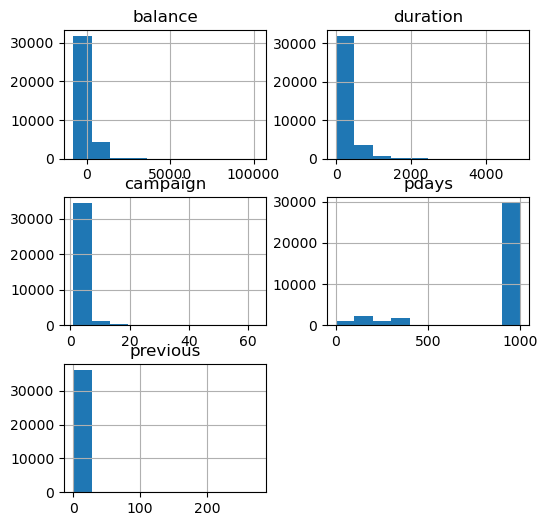

In [5]:
import matplotlib.pyplot as plt
columns = ['balance', 'duration', 'campaign', 'pdays', 'previous']
train_data[columns].hist(figsize=(6,6))

In [6]:
# 对偏态数据进行处理
import numpy as np
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
def skewness(df):
    df['balance_log'] = df['balance'].map(lambda x : np.log(x+8020))
    df['pdays_log'] = boxcox1p(df['pdays'], boxcox_normmax(df['pdays'] + 2))
    df.drop(columns=['balance', 'pdays'], inplace=True)
    columns = ['duration','campaign','previous']
    for i in columns:
        df[i+'_log'] = df[i].map(lambda x : x**(1/2))
        df.drop(columns=[i], inplace=True)
    return df
train_data = skewness(train_data)
test_data = skewness(test_data)

array([[<Axes: title={'center': 'balance_log'}>,
        <Axes: title={'center': 'duration_log'}>],
       [<Axes: title={'center': 'campaign_log'}>,
        <Axes: title={'center': 'pdays_log'}>],
       [<Axes: title={'center': 'previous_log'}>, <Axes: >]], dtype=object)

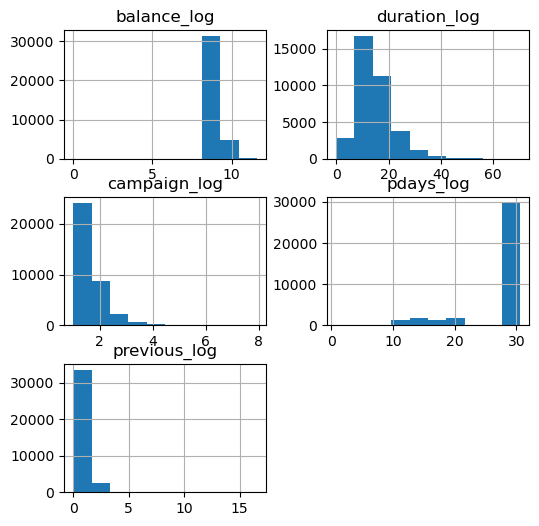

In [7]:
df2 = train_data[['balance_log', 'duration_log', 'campaign_log', 'pdays_log', 'previous_log']]
df2.hist(figsize=(6,6))

### Standardization

In [8]:
columns = ['balance_log', 'duration_log', 'campaign_log', 'pdays_log', 'previous_log']
def standardization(df):
    df[columns] = df[columns].apply(lambda x:(x-x.mean())/x.std())
    return df
train_data = standardization(train_data)
test_data = standardization(test_data)
train_data.iloc[:,:-5]#.describe()

,housing,loan,default,age_0,age_1,age_2,age_3,marital_divorced,marital_married,marital_single,...,job_technician,job_unemployed,education_primary,education_secondary,education_tertiary,contact_cellular,contact_telephone,poutcome_failure,poutcome_other,poutcome_success
0,1,1,0,0,0,1,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0
1,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,1,1,0,0
2,1,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,1,0
3,1,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,1,1,0,0
36164,1,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,1
36165,1,0,0,0,0,1,0,0,1,0,...,1,0,0,1,0,1,0,1,0,0
36166,0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0


### Oversampling

In [9]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(train_data, y)
y = np.array(y).reshape(-1,1)

In [10]:
train_data_after_preprocess = X
train_data_after_preprocess['y'] = y
train_data_after_preprocess.groupby('y')['loan'].count()

y
0    31937
1    31937
Name: loan, dtype: int64

### 保存数据集

In [11]:
train_data_after_preprocess.to_csv('train_data_after_preprocess.csv', index=False)
test_data.to_csv('test_data_after_preprocess.csv', index=False)